In [1]:
# ----------------------------
# Project 3 — Modular Portfolio Backtesting Engine
# with Rolling (Dynamic) Sharpe + Volatility Weighting
# ----------------------------
# Author: Rein | Pixel Sky Solutions
# Course: Python–Finance Master Plan
# ----------------------------

In [2]:
import os
import warnings
import logging
from typing import Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# --- Aesthetics ---
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
pd.options.display.float_format = "{:,.4f}".format

# --- Directories ---
BASE_DIR = os.path.abspath(".")
DATA_DIR = "data"
CHARTS_DIR = os.path.join(BASE_DIR, "charts")
# os.makedirs(DATA_DIR, exist_ok=True)
# os.makedirs(CHARTS_DIR, exist_ok=True)

# Input CSVs
ml_file = os.path.join(DATA_DIR, "project1_backtest_results.csv")
mom_file = os.path.join(DATA_DIR, "project2_best_backtest_ema_50_200.csv")

INITIAL_CAPITAL = 10_000

In [3]:
# Main Backtest Function

In [10]:
def backtest_portfolio_from_files(
    ml_path,
    mom_path,
    initial_capital=10_000,
    rolling_window=63,
    alpha=0.7,
    rebalance="monthly",
    min_obs=30,
    save_outputs=True,
    output_dir="./"
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Modular Portfolio Backtesting Engine with Rolling Sharpe + Volatility Weighting
    Combines ML and Momentum strategies into a dynamic portfolio.
    """

    # --- Logging setup ---
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s | %(levelname)s | %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )
    logging.info("🚀 Starting Dynamic Portfolio Backtest...")

    # --- Load CSVs ---
    ml = pd.read_csv(ml_path, parse_dates=True, index_col=0)
    mom = pd.read_csv(mom_path, parse_dates=True, index_col=0)
    logging.info(f"Loaded ML: {ml.shape}, Momentum: {mom.shape}")

    # --- Ensure both DataFrames have proper 'Date' index ---
    def ensure_date_column(df: pd.DataFrame, name: str):
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        elif df.index.name and "date" in df.index.name.lower():
            df = df.reset_index().rename(columns={df.index.name: "Date"})
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        else:
            df = df.reset_index().rename(columns={"index": "Date"})
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

        df = df.dropna(subset=["Date"])
        df = df.sort_values("Date").drop_duplicates("Date")
        df.set_index("Date", inplace=True)
        return df

    ml = ensure_date_column(ml, "ML")
    mom = ensure_date_column(mom, "Momentum")

    # --- Add suffix to prevent overlapping columns ---
    ml = ml.add_suffix("_ml")
    mom = mom.add_suffix("_mom")

    # --- Identify main equity columns ---
    for col in ml.columns:
        if "equity" in col.lower():
            ml = ml.rename(columns={col: "ml_equity"})
            break
    for col in mom.columns:
        if "equity" in col.lower():
            mom = mom.rename(columns={col: "mom_equity"})
            break

    # --- Merge dataframes ---
    merged = pd.merge(
        ml.reset_index(),
        mom.reset_index(),
        on="Date",
        how="inner",
        suffixes=("_ml", "_mom")
    ).set_index("Date")

    # --- Remove fully empty rows ---
    merged = merged.dropna(how="all")
    logging.info(f"✅ Merged DataFrame shape after cleaning: {merged.shape}")

    # --- Compute daily returns ---
    merged["ml_ret"] = merged["ml_equity"].pct_change().replace([np.inf, -np.inf], 0).fillna(0)
    merged["mom_ret"] = merged["mom_equity"].pct_change().replace([np.inf, -np.inf], 0).fillna(0)

    # --- Rolling volatility and Sharpe ---
    merged["vol_ml"] = merged["ml_ret"].rolling(rolling_window).std()
    merged["vol_mom"] = merged["mom_ret"].rolling(rolling_window).std()
    merged["sharpe_ml"] = (merged["ml_ret"].rolling(rolling_window).mean() / merged["vol_ml"]).fillna(0)
    merged["sharpe_mom"] = (merged["mom_ret"].rolling(rolling_window).mean() / merged["vol_mom"]).fillna(0)

    # --- Clean inf/nan ---
    merged = merged.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(0)

    # --- Inverse-vol weighting ---
    inv_vol = 1 / merged[["vol_ml", "vol_mom"]].replace(0, np.nan)
    inv_vol = inv_vol.div(inv_vol.sum(axis=1), axis=0).fillna(0.5)

    merged["comb_ml"] = alpha * merged["sharpe_ml"] + (1 - alpha) * inv_vol["vol_ml"]
    merged["comb_mom"] = alpha * merged["sharpe_mom"] + (1 - alpha) * inv_vol["vol_mom"]

    # --- Rebalance dates ---
    if rebalance == "monthly":
        rebal_dates = merged.resample("M").last().index
    elif rebalance == "weekly":
        rebal_dates = merged.resample("W").last().index
    else:
        rebal_dates = merged.index

    # --- Dynamic weights ---
    weights = pd.DataFrame(index=merged.index, columns=["w_ml", "w_mom"], dtype=float)
    for d in rebal_dates:
        idx = merged.index.get_indexer([d], method="nearest")[0]
        if idx < min_obs:
            continue
        w_ml_val = merged.iloc[idx]["comb_ml"]
        w_mom_val = merged.iloc[idx]["comb_mom"]
        s = w_ml_val + w_mom_val
        if not np.isfinite(s) or s == 0:
            weights.iloc[idx] = inv_vol.iloc[idx].values
        else:
            weights.iloc[idx] = [w_ml_val / s, w_mom_val / s]

    weights = weights.ffill().bfill()
    merged["w_ml_dynamic"], merged["w_mom_dynamic"] = weights["w_ml"], weights["w_mom"]

    # --- Compute strategy returns & equity curves ---
    merged["ret_ml"] = merged["ml_ret"] * merged["w_ml_dynamic"]
    merged["ret_mom"] = merged["mom_ret"] * merged["w_mom_dynamic"]
    merged["ret_dynamic"] = merged["ret_ml"] + merged["ret_mom"]

    merged["equity_dynamic"] = initial_capital * (1 + merged["ret_dynamic"]).cumprod()
    merged["equity_equal"] = initial_capital * (1 + 0.5 * (merged["ml_ret"] + merged["mom_ret"])).cumprod()
    merged["equity_invvol"] = initial_capital * (
        1 + (inv_vol["vol_ml"] * merged["ml_ret"] + inv_vol["vol_mom"] * merged["mom_ret"])
    ).cumprod()

    # --- Normalize extreme values ---
    for c in ["equity_dynamic", "equity_equal", "equity_invvol"]:
        if merged[c].max() > 1e6:
            logging.warning(f"⚠️ Unrealistic growth detected in {c}. Normalizing...")
            merged[c] = merged[c] / merged[c].max()

    # --- Rolling metrics CSV ---
    roll_perf = merged[["ml_ret", "mom_ret", "ret_dynamic"]].rolling(rolling_window).mean()
    if save_outputs:
        os.makedirs(output_dir, exist_ok=True)
        roll_perf.to_csv(os.path.join(output_dir, "rolling_metrics.csv"))

    # --- Performance summary ---
    def perf_summary(equity):
        ret = equity.pct_change().dropna()
        total = equity.iloc[-1] / equity.iloc[0] - 1
        cagr = (1 + total) ** (252 / len(equity)) - 1
        vol = ret.std() * np.sqrt(252)
        sharpe = ret.mean() / ret.std() * np.sqrt(252) if ret.std() != 0 else 0
        maxdd = (equity / equity.cummax() - 1).min()
        return [total, cagr, vol, sharpe, maxdd]

    perf = pd.DataFrame([
        ["ML", *perf_summary(merged["ml_equity"])],
        ["Momentum", *perf_summary(merged["mom_equity"])],
        ["Equal", *perf_summary(merged["equity_equal"])],
        ["InvVol", *perf_summary(merged["equity_invvol"])],
        ["Dynamic", *perf_summary(merged["equity_dynamic"])]
    ], columns=["Strategy", "Total Return", "CAGR", "Volatility", "Sharpe", "Max Drawdown"])

    # --- Save outputs ---
    if save_outputs:
        merged.to_csv(os.path.join(output_dir, "merged_backtest_output.csv"))
        perf.to_csv(os.path.join(output_dir, "performance_summary.csv"), index=False)
        logging.info("💾 Results saved to output directory.")

    # --- Plot equity curves ---
    plt.figure(figsize=(12, 6))
    for col in ["ml_equity", "mom_equity", "equity_equal", "equity_invvol", "equity_dynamic"]:
        plt.plot(merged.index, merged[col] / merged[col].iloc[0], label=col)
    plt.legend()
    plt.title("📈 Portfolio Equity Curves")
    plt.tight_layout()
    plt.show()

    logging.info("✅ Backtest complete.")
    return merged, perf

In [8]:
# --- Run backtest ---

2025-10-18 10:59:07 | INFO | 🚀 Starting Dynamic Portfolio Backtest...
2025-10-18 10:59:07 | INFO | Loaded ML: (1987, 16), Momentum: (2006, 8)
2025-10-18 10:59:07 | INFO | ✅ Merged DataFrame shape after cleaning: (502, 24)
2025-10-18 10:59:07 | WARNING | ⚠️ Unrealistic growth detected in equity_dynamic. Normalizing...
2025-10-18 10:59:07 | WARNING | ⚠️ Unrealistic growth detected in equity_equal. Normalizing...
2025-10-18 10:59:07 | WARNING | ⚠️ Unrealistic growth detected in equity_invvol. Normalizing...
2025-10-18 10:59:07 | INFO | 💾 Results saved to output directory.


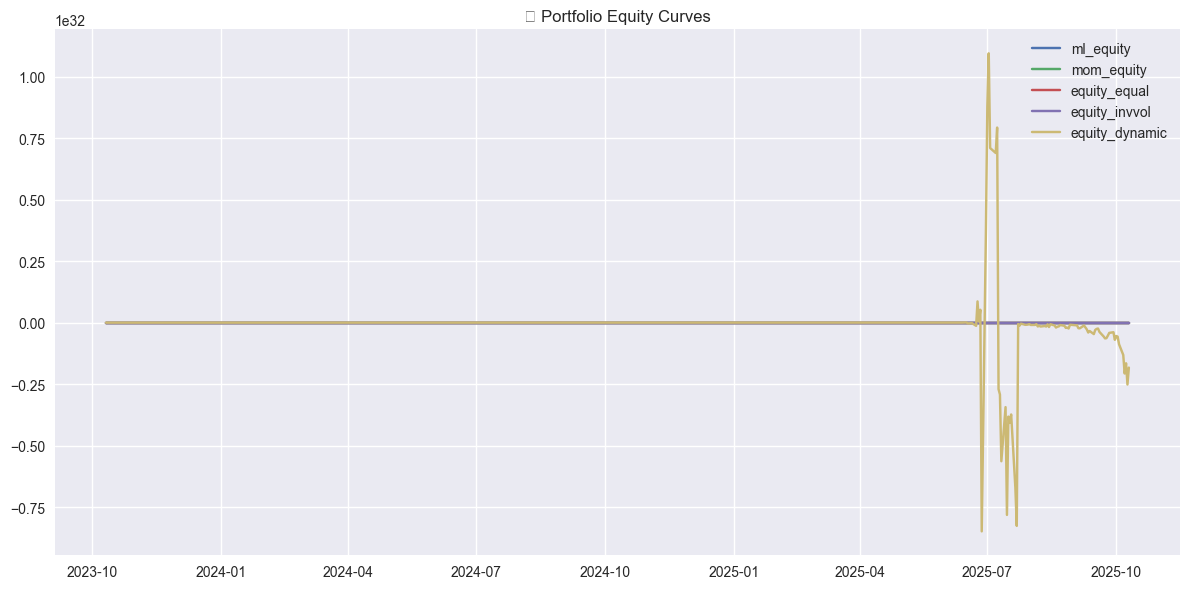

2025-10-18 10:59:08 | INFO | ✅ Backtest complete.



✅ Dynamic Backtest Complete — Performance Summary:
   Strategy                                     Total Return    CAGR  \
0        ML                                           0.9533  0.3995   
1  Momentum                                          -1.0000 -1.0000   
2     Equal                                          -1.0000 -1.0000   
3    InvVol                                          -1.0000 -1.0000   
4   Dynamic -18,260,427,218,377,991,405,717,141,061,632.0000     NaN   

   Volatility  Sharpe  Max Drawdown  
0     11.0698  4.0338       -0.7408  
1     12.8581 -3.4089       -1.0941  
2      8.6564  0.0475       -1.0000  
3      8.4993  0.4219       -1.0000  
4     43.6630  1.8636  -79,216.2119  


In [11]:
merged_df, perf = backtest_portfolio_from_files(
    ml_path=ml_file,
    mom_path=mom_file,
    rolling_window=63,
    alpha=0.7,
    rebalance="monthly",
    min_obs=30,
    save_outputs=True,
    output_dir=DATA_DIR
)

print("\n✅ Dynamic Backtest Complete — Performance Summary:")
print(perf.round(5))